# Getting Started

## General Tips
In each homework problem, you will implement and train various diffusion models.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
# get to the parent dir of mai_dul repo
import os
# os.chdir('../../')
os.getcwd()

'/home/ordem/PycharmProjects/MAI_DUL_WS24/homeworks/hw4'

In [2]:
# install latest version deepul package
# !pip install -e .

In [3]:
from deepul.hw4_helper import *
import warnings
import numpy as np
import torch
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

from deepul.hw4_helper import q2_save_results
from models.Diffusion2 import Diffusion2
warnings.filterwarnings('ignore')

# Question 2: Pixel-Space Diffusion on CIFAR-10 [30pt]

In this question, we will train pixel-space UNet diffusion model on CIFAR-10

Execute the cell below to visualize our datasets.

100%|██████████| 170498071/170498071 [02:17<00:00, 1235695.00it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


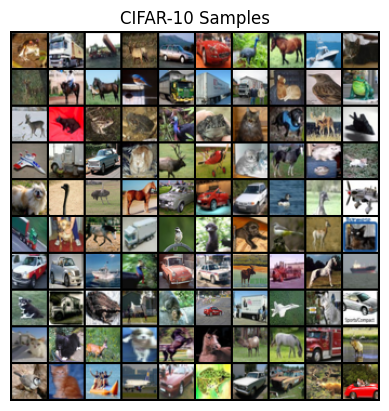

In [4]:
visualize_q2_data()

We'll use a UNet architecture similar to the original [DDPM](https://arxiv.org/abs/2006.11239) paper. We provide the following pseudocode for each part of the model:
```
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = np.exp(-np.log(max_period) * np.arange(0, half, dtype=float32) / half)
    args = timesteps[:, None].astype(float32) * freqs[None]
    embedding = cat([np.cos(args), np.sin(args)], axis=-1)
    if dim % 2:
        embedding = cat([embedding, np.zeros_like(embedding[:, :1])], axis=-1)
    return embedding

ResidualBlock(in_channels, out_channels, temb_channels)
    Given x, temb
    h = Conv2d(in_channels, out_channels, 3, padding=1)(x)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    temb = Linear(temb_channels, out_channels)(temb)
    h += temb[:, :, None, None] # h is BxDxHxW, temb is BxDx1x1
    
    h = Conv2d(out_channels, out_channels, 3, padding=1)(h)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    if in_channels != out_channels:
        x = Conv2d(in_channels, out_channels, 1)(x)
    return x + h
    
Downsample(in_channels)
    Given x
    return Conv2d(in_channels, in_channels, 3, stride=2, padding=1)(x)

Upsample(in_channels)
    Given x
    x = interpolate(x, scale_factor=2)
    x = Conv2d(in_channels, in_channels, 3, padding=1)(x)
    return x
    
UNet(in_channels, hidden_dims, blocks_per_dim)
    Given x, t
    temb_channels = hidden_dims[0] * 4
    emb = timestep_embedding(t, hidden_dims[0])
    emb = Sequential(Linear(hidden_dims[0], temb_channels), SiLU(), Linear(temb_channels, temb_channels))(emb)
    
    h = Conv2d(in_channels, hidden_dims[0], 3, padding=1)(x)
    hs = [h]
    prev_ch = hidden_dims[0]
    down_block_chans = [prev_ch]
    for i, hidden_dim in enumerate(hidden_dims):
        for _ in range(blocks_per_dim):
            h = ResidualBlock(prev_ch, hidden_dim, temb_channels)(h, emb)
            hs.append(h)
            prev_ch = hidden_dim
            down_block_chans.append(prev_ch)
        if i != len(hidden_dims) - 1:
            h = Downsample(prev_ch)(h)
            hs.append(h)
            down_block_chans.append(prev_ch)
    
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    
    for i, hidden_dim in list(enumerate(hidden_dims))[::-1]:
        for j in range(blocks_per_dim + 1):
            dch = down_block_chans.pop()
            h = ResidualBlock(prev_ch + dch, hidden_dim, temb_channels)(cat(h, hs.pop()), emb)
            prev_ch = hidden_dim
            if i and j == blocks_per_dim:
                h = Upsample(prev_ch)(h)
    
    h = GroupNorm(num_groups=8, num_channels=prev_ch)(h)
    h = SiLU()(h)
    out = Conv2d(prev_ch, in_channels, 3, padding=1)(h)
    return out
```

**Hyperparameter details**
* Normalize data to [-1, 1]
* UNET with hidden_dims as [64, 128, 256, 512] and 2 blocks_per_dim
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* For diffusion schedule, sampling and loss, use the same setup as Q1

You may also find it helpful to clip $\hat{x} = \frac{x_t - \sigma_t \hat{\epsilon}}{\alpha_t}$ to [-1, 1] during each sampling step.

In [ ]:
def q2(train_data, test_data):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific number of diffusion timesteps. Do this for 10 evenly logarithmically spaced integers
      1 to 512, i.e. np.power(2, np.linspace(0, 9, 10)).astype(int)
    """

    train_losses = []
    test_losses = []
    batch_size = 128
    max_epochs = 60
    learning_rate = 1e-3
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_max = torch.tensor(train_data.min(axis=0), dtype=torch.float32).transpose(-1, 0).to(device)
    train_min = torch.tensor(train_data.max(axis=0), dtype=torch.float32).transpose(-1, 0).to(device)

    def normalize_transform(data):
        return (2 * (data - train_min) / (train_max - train_min)) - 1

    def denormalize_transform(data):
        return (data + 1) / 2 * (train_max - train_min) + train_min

    train_dataset = TensorDataset(torch.tensor(train_data, dtype=torch.float32).transpose(-1, 1))
    test_dataset = TensorDataset(torch.tensor(test_data, dtype=torch.float32).transpose(-1, 1))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    model = Diffusion2(in_channels=3, hidden_dims=[64, 128, 256, 512], blocks_per_dim=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in tqdm(range(max_epochs)):
        for [batch_x] in train_loader:
            optimizer.zero_grad()
            batch_x = normalize_transform(batch_x.to(device))
            t, x_t, epsilon = model.generate_noise_steps(batch_x, device=device)
            epsilon_hat = model.forward(x_t, t)
            loss = model.loss_function(epsilon_hat, epsilon)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        model.eval()
        with torch.no_grad():
            test_batch_losses = []
            for [batch_x] in test_loader:
                batch_x = normalize_transform(batch_x.to(device))
                t, x_t, epsilon = model.generate_noise_steps(batch_x, device=device)
                epsilon_hat = model.forward(x_t, t)
                loss = model.loss_function(epsilon_hat, epsilon)
                test_batch_losses.append(loss.item())
            test_losses.append(np.array(test_batch_losses).mean().item())
        model.train()
    samples = []
    for num_steps in np.power(2, np.linspace(0, 9, 9)).astype(int):
        samples = denormalize_transform(model.generate(2000, num_steps, device)).numpy(force=True)
        all_samples.append(samples)
    samples = np.array(all_samples)
    return train_losses, test_losses, samples

In [ ]:
q2_save_results(q2)